In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

pd.set_option('display.float_format',lambda x: '%.1f' %x)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the datasets for 2019 data
data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2019.csv', header=0, encoding = 'unicode_escape')
print("----- Feature Set ----- \n", list(data2019.columns))

data2019 = data2019.fillna(0)

----- Feature Set ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']


In [3]:
# Function to identify whether a product is new or not and add that as a feature in the dataset
def add_new_product(data):
    data.loc[(data.Year_SKU_Introduced < 2019) | ((data['Year_SKU_Introduced']).isnull()), 'NewProduct'] = '0' # Existing product
    data.loc[data.Year_SKU_Introduced >= 2019, 'NewProduct'] = '1' # New product
    return (data)

In [4]:
# Function to add 'Demand' as a feature in the dataset
def add_demand(data):
    data.loc[data.PlannedUnits != 0, 'Demand'] = data['PlannedUnits']
    data.loc[data.PlannedUnits == 0, 'Demand'] = data['PDXPlannedUnits']

    return (data)

In [5]:
# # Function to Group products by Experiment Id
# def group_by_expId(data):
#   groupedData = data.groupby(['Experiment_Id']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
#   # Remove the index and flatten the 2019 dataset
#   groupedData.reset_index(inplace=True)
#   print("Grouped dataset (by Experiment Id) shape: ", groupedData.shape)
#   return (groupedData)

In [6]:
# # Function to Group products by Experiment Id and Seasons
# def group_by_Seasons(data):
#   groupedData = data.groupby(['Experiment_Id', 'Season']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
#   # Remove the index and flatten the 2019 dataset
#   groupedData.reset_index(inplace=True)
#   print("Grouped dataset (by Experiment Id and Seasons) shape: ", groupedData.shape)
#   return (groupedData)

In [7]:
# # Function to Group products by Experiment Id and Categorical Descriptions
# def group_by_Categoricals(data):
#   groupedData = data.groupby(['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
#   # Remove index and flatten the dataset
#   groupedData.reset_index(inplace=True)
#   print("Grouped dataset (Experiment Id and Categoricals) shape: ", groupedData.shape)
#   return (groupedData)

In [8]:
# Function to Group products by Experiment Id, Seasons and Categorical Descriptions
def group_by_SeasonsAndCategoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Season', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (Experiment Id, Seasons and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [9]:
# Function to select the Top80 selling products
def get_Top80(data):
    # Calculate % Ordered_Units 
    totalOrdUnits = data['Ordered_Units'].sum()
    data['Pct_OrdUnits'] = (data['Ordered_Units']/totalOrdUnits)*100

    # Sort the dataset based on % Ordered_Units 
    data = data.sort_values('Pct_OrdUnits',ascending=False)
    data['Cumsum_Pct_OrdUnits'] = data['Pct_OrdUnits'].cumsum()

    # Find the orders with Top 80 sales (ordered units)
    dataTop80 = data[data.Cumsum_Pct_OrdUnits <= 80]

    # Drop the Pct_OrdUnits and Cumsum_Pct_OrdUnits columns
    dataTop80 = dataTop80.drop(['Pct_OrdUnits', 'Cumsum_Pct_OrdUnits'], axis=1)

    print("Dataset shape after retaining the Top80 selling products: ", dataTop80.shape)
    return (dataTop80)

In [10]:
# Function for K-Means clustering
def KMeans_clusterLabels(data, n):# Cluster data using k-means and get the cluster labels
    model = KMeans(n_clusters=n, random_state=1)
    model.fit(data)
    model2019 = model.predict(data)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=model2019, s=50, cmap='viridis')
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    return (cluster_label)

In [11]:
# Function for creating Classification Dataset
def create_Classification_Dataset(data):
    # Add the new feature 'Suggested_Storage_Type' and the target 'Class' based on the 'Avg_Daily_Volume'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Suggested_Storage_Type'] = 'Flat Rack'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Class'] = '0'
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Suggested_Storage_Type'] = 'Flow Rack' 
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Class'] = '1' 
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Suggested_Storage_Type'] = 'Big Pack'
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Class'] = '2'

    return (data)

In [12]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [13]:
# Remove those Data for which there are no Orders
dfOrders2019 = data2019[data2019.Orders != 0]

# Add a new feature to identify whether a product is New or Existing
dfOrders2019 = add_new_product(dfOrders2019)

# Add a new feature 'Demand'
dfOrders2019 = add_demand(dfOrders2019)

# # Group 2019 dataset by Experiment_Id
# grouped2019 = group_by_expId(dfOrders2019)

# # Group 2019 dataset by Experiment_Id and Seasons
# groupedSeasons2019 = group_by_Seasons(dfOrders2019)
# groupedSpring2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 0].drop(['Season'], axis=1)
# groupedFall2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 1].drop(['Season'], axis=1)
# print("Spring2019 dataset shape: ", groupedSpring2019.shape)
# print("Fall2019 dataset shape: ", groupedFall2019.shape)

# # Group 2019 dataset by Experiment_Id and Categorical Descriptions
# groupedCat2019 = group_by_Categoricals(dfOrders2019)

# Group 2019 dataset by Experiment_Id, Seasons and Categoricals
groupedCatSeasons2019 = group_by_SeasonsAndCategoricals(dfOrders2019)

groupedCatSpring2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 0].drop(['Season'], axis=1)
groupedCatFall2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 1].drop(['Season'], axis=1)
print("Spring2019 with categorical dataset shape: ", groupedCatSpring2019.shape)
print("Fall2019 with categorical dataset shape: ", groupedCatFall2019.shape)

# Get Top80 most sold products
# df2019_Top80 = get_Top80(grouped2019)
# dfSpring2019_Top80 = get_Top80(groupedSpring2019)
# dfFall2019_Top80 = get_Top80(groupedFall2019)

# dfCat2019_Top80 = get_Top80(groupedCat2019)
dfCatSpring2019_Top80 = get_Top80(groupedCatSpring2019)
dfCatFall2019_Top80 = get_Top80(groupedCatFall2019)

print("\n----- Feature Set : dfCatSpring2019_Top80 ----- \n", list(dfCatSpring2019_Top80.columns))
print("\n----- Feature Set : dfCatFall2019_Top80 ----- \n", list(dfCatFall2019_Top80.columns))

Grouped dataset (Experiment Id, Seasons and Categoricals) shape:  (39596, 21)
Spring2019 with categorical dataset shape:  (20338, 20)
Fall2019 with categorical dataset shape:  (19258, 20)
Dataset shape after retaining the Top80 selling products:  (2452, 20)
Dataset shape after retaining the Top80 selling products:  (3266, 20)

----- Feature Set : dfCatSpring2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']

----- Feature Set : dfCatFall2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']


In [14]:
# # Cluster 2019 dataset (without categorical descriptions) by K-Means Clustering
# df2019_Top80_kmeans = df2019_Top80.copy()

# # Add the cluster labels to the dataset
# # Number of clusters : 3
# cluster3_label = KMeans_clusterLabels(df2019_Top80, 3)
# df2019_Top80_kmeans['Cluster3_Label'] = cluster3_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster3_Label'].value_counts())

In [15]:
# # Number of clusters : 4
# cluster4_label = KMeans_clusterLabels(df2019_Top80, 4)
# df2019_Top80_kmeans['Cluster4_Label'] = cluster4_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster4_Label'].value_counts())

In [16]:
# # Remove the order details and retain only the cluster labels along with the Experiment_Id
# df2019_Top80_kmeans_labels = df2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
# print("Dataset shape: ", df2019_Top80_kmeans_labels.shape)

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the 3-cluster model
# accuracyCluster3 = silhouette_score(df2019_Top80, cluster3_label)
# print("Accuracy of kmeans with n=3: ", accuracyCluster3)
# # Evaluate the 4-cluster model
# accuracyCluster4 = silhouette_score(df2019_Top80, cluster4_label)
# print("Accuracy of kmeans with n=4: ", accuracyCluster4)

In [17]:
# # Cluster Spring 2019 and Fall 2019 datasets (without categorical descriptions) by K-Means Clustering
# # Kmeans with n=3 on Spring2019 Data
# dfSpring2019_Top80_kmeans = dfSpring2019_Top80.copy()
# spring_cluster3_label = KMeans_clusterLabels(dfSpring2019_Top80, 3)
# dfSpring2019_Top80_kmeans['Cluster3_Label'] = spring_cluster3_label

# print("\n----- Spring 2019 Cluster_Label counts -----")
# print(dfSpring2019_Top80_kmeans['Cluster3_Label'].value_counts())

# # Remove the order details and retain only the cluster labels along with the Experiment_Id
# dfSpring2019_Top80_kmeans_labels = dfSpring2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
# print("Dataset shape: ", dfSpring2019_Top80_kmeans_labels.shape)

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the 3-cluster model for Spring2019
# accuracySpring = silhouette_score(dfSpring2019_Top80, spring_cluster3_label)
# print("Accuracy of kmeans with n=3 on Spring2019: ", accuracySpring)

# # Kmeans with n=3 on Fall2019 Data
# dfFall2019_Top80_kmeans = dfFall2019_Top80.copy()
# fall_cluster3_label = KMeans_clusterLabels(dfFall2019_Top80, 3)
# dfFall2019_Top80_kmeans['Cluster3_Label'] = fall_cluster3_label

# print("\n----- Fall 2019 Cluster_Label counts -----")
# print(dfFall2019_Top80_kmeans['Cluster3_Label'].value_counts())

# # Remove the order details and retain only the cluster labels along with the Experiment_Id
# dfFall2019_Top80_kmeans_labels = dfFall2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
# print("Dataset shape: ", dfFall2019_Top80_kmeans_labels.shape)

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the 3-cluster model for Fall2019
# accuracyFall = silhouette_score(dfFall2019_Top80, fall_cluster3_label)
# print("Accuracy of kmeans with n=3 on Fall2019: ", accuracyFall)

In [18]:
CLUSTERING_FEATURE_SET_1 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_2 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_3 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
CLUSTERING_FEATURE_SET_4 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']

dfSpring2019_Top80_kmeans = dfCatSpring2019_Top80[CLUSTERING_FEATURE_SET_4]
dfFall2019_Top80_kmeans = dfCatFall2019_Top80[CLUSTERING_FEATURE_SET_4]

In [19]:
corr = dfSpring2019_Top80_kmeans.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,-0.196251,-0.0414145,-0.306544,0.517657
Orders,-0.196251,1,0.466891,0.303078,0.0716816
Avg_Daily_Ordered_Units,-0.0414145,0.466891,1,-0.0870764,0.450503
Days_Ordered,-0.306544,0.303078,-0.0870764,1,-0.350194
Avg_Daily_Volume,0.517657,0.0716816,0.450503,-0.350194,1


In [20]:
corr = dfFall2019_Top80_kmeans.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,-0.132241,-0.0321818,-0.172386,0.376825
Orders,-0.132241,1,0.346791,0.155732,0.0254231
Avg_Daily_Ordered_Units,-0.0321818,0.346791,1,-0.303482,0.478287
Days_Ordered,-0.172386,0.155732,-0.303482,1,-0.303415
Avg_Daily_Volume,0.376825,0.0254231,0.478287,-0.303415,1



----- Spring 2019 Cluster_Label counts with n=3 -----
0    2329
2     107
1      16
Name: Cluster3_Label, dtype: int64
Accuracy of kmeans with n=3 on Spring2019:  0.8729016528752543


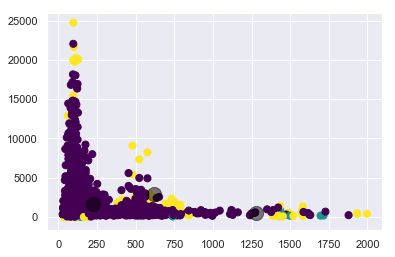

In [21]:
# Cluster Spring 2019 by K-Means Clustering
# Kmeans with n=3 on Spring2019 Data
spring_cluster3_label = KMeans_clusterLabels(dfSpring2019_Top80_kmeans, 3)
dfCatSpring2019_Top80['Cluster3_Label'] = spring_cluster3_label

print("\n----- Spring 2019 Cluster_Label counts with n=3 -----")
print(dfCatSpring2019_Top80['Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80_kmeans, spring_cluster3_label)
print("Accuracy of kmeans with n=3 on Spring2019: ", accuracySpring)


----- Spring 2019 Cluster_Label counts with n=4 -----
0    2314
3     115
1      14
2       9
Name: Cluster4_Label, dtype: int64
Accuracy of kmeans with n=4 on Spring2019:  0.8601427855603824


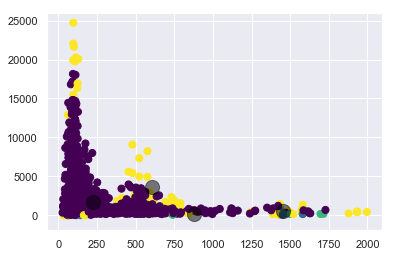

In [22]:
# Cluster Spring 2019 by K-Means Clustering
# Kmeans with n=4 on Spring2019 Data
spring_cluster4_label = KMeans_clusterLabels(dfSpring2019_Top80_kmeans, 4)
dfCatSpring2019_Top80['Cluster4_Label'] = spring_cluster4_label

print("\n----- Spring 2019 Cluster_Label counts with n=4 -----")
print(dfCatSpring2019_Top80['Cluster4_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 4-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80_kmeans, spring_cluster4_label)
print("Accuracy of kmeans with n=4 on Spring2019: ", accuracySpring)


----- Fall 2019 Cluster_Label counts with n=3 -----
0    3154
2      92
1      20
Name: Cluster3_Label, dtype: int64
Accuracy of kmeans with n=3 on Fall2019:  0.8909212866871662


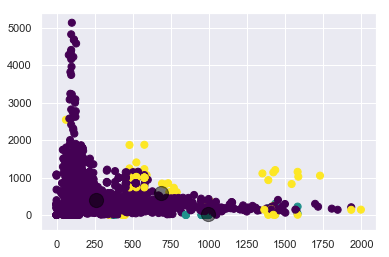

In [23]:
# Cluster Fall 2019 by K-Means Clustering
# Kmeans with n=3 on Fall2019 Data
fall_cluster3_label = KMeans_clusterLabels(dfFall2019_Top80_kmeans, 3)
dfCatFall2019_Top80['Cluster3_Label'] = fall_cluster3_label

print("\n----- Fall 2019 Cluster_Label counts with n=3 -----")
print(dfCatFall2019_Top80['Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80_kmeans, fall_cluster3_label)
print("Accuracy of kmeans with n=3 on Fall2019: ", accuracyFall)


----- Fall 2019 Cluster_Label counts with n=4 -----
0    3148
2      91
3      16
1      11
Name: Cluster4_Label, dtype: int64
Accuracy of kmeans with n=4 on Fall2019:  0.8763656503858084


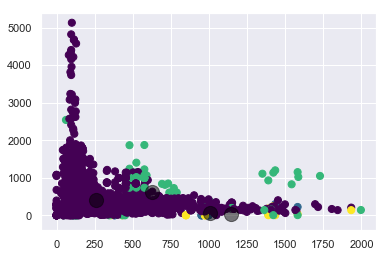

In [24]:
# Cluster Fall 2019 by K-Means Clustering
# Kmeans with n=4 on Fall2019 Data
fall_cluster4_label = KMeans_clusterLabels(dfFall2019_Top80_kmeans, 4)
dfCatFall2019_Top80['Cluster4_Label'] = fall_cluster4_label

print("\n----- Fall 2019 Cluster_Label counts with n=4 -----")
print(dfCatFall2019_Top80['Cluster4_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 4-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80_kmeans, fall_cluster4_label)
print("Accuracy of kmeans with n=4 on Fall2019: ", accuracyFall)

In [25]:
# Create datasets for Classification (2019, Spring2019 and Fall2019)
# df2019 = create_Classification_Dataset(dfCat2019_Top80, df2019_Top80_kmeans_labels)
# print("2019 dataset shape: ", df2019.shape)
# print("----- Feature Set ----- \n", list(df2019.columns))

dfSpring2019 = create_Classification_Dataset(dfCatSpring2019_Top80)
print("Spring 2019 dataset shape: ", dfSpring2019.shape)
print("----- Feature Set ----- \n", list(dfSpring2019.columns))
print("\n")
dfFall2019 = create_Classification_Dataset(dfCatFall2019_Top80)
print("Fall 2019 dataset shape: ", dfFall2019.shape)
print("----- Feature Set ----- \n", list(dfFall2019.columns))

Spring 2019 dataset shape:  (2452, 24)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Cluster4_Label', 'Suggested_Storage_Type', 'Class']


Fall 2019 dataset shape:  (3266, 24)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Cluster4_Label', 'Suggested_Storage_Type', 'Class']


In [26]:
# Corelation matrix
# corr = df2019[['Volume', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']].corr()
# corr.style.background_gradient(cmap='coolwarm', axis=None)

In [27]:
# # Create one-vs-rest multinomial logistic regression object
# clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
# FEATURE_SET = ['Volume', 'NewProduct']
# TARGET_CLUSTER3 = ['Cluster3_Label']
# TARGET_CLUSTER4 = ['Cluster4_Label']
# TARGET_CLASS = ['Class']

# #2019 DATA
# X = df2019[FEATURE_SET] # Training Set
# y1 = df2019[TARGET_CLUSTER3] # Target: 3-cluster labels
# y2 = df2019[TARGET_CLUSTER4] # Target: 4-cluster labels
# y3 = df2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of 2019
# model1 = clf.fit(X, y1)
# accuracy1 = model1.score(X, y1)
# print("Accuracy of 2019 data with 3-cluster labels: ", accuracy1)

# # Train Model and get the Accuracy Score
# # Target: 4-cluster labels of 2019
# model2 = clf.fit(X, y2)
# accuracy2 = model2.score(X, y2)
# print("Accuracy of 2019 data with 4-cluster labels: ", accuracy2)

# # Target: Class (Dale's classification)
# model3 = clf.fit(X, y3)
# model3.score(X, y3)
# accuracy3 = model3.score(X, y3)
# print("Accuracy of 2019 data with class labels: ", accuracy3)

# # SPRING2019 DATA
# spring_X = dfSpring2019[FEATURE_SET] # Training Set
# spring_y1 = dfSpring2019[TARGET_CLUSTER3] # Target: 3-cluster labels
# spring_y2 = dfSpring2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Spring2019
# spring_model1 = clf.fit(spring_X, spring_y1)
# spring_accuracy1 = spring_model1.score(spring_X, spring_y1)
# print("Accuracy of Spring 2019 data with 3-cluster labels: ", spring_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# # Target: 3-cluster labels of Spring2019
# spring_model2 = clf.fit(spring_X, spring_y2)
# spring_accuracy2 = spring_model2.score(spring_X, spring_y2)
# print("Accuracy of Spring 2019 data with class labels: ", spring_accuracy2)

# # FALL2019 DATA
# fall_X = dfFall2019[FEATURE_SET] # Training Set
# fall_y1 = dfFall2019[TARGET_CLUSTER3] # Target: 3-cluster labels
# fall_y2 = dfFall2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Fall2019
# fall_model1 = clf.fit(fall_X, fall_y1)
# fall_accuracy1 = fall_model1.score(fall_X, fall_y1)
# print("Accuracy of Fall 2019 data with 3-cluster labels: ", fall_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# fall_model2 = clf.fit(fall_X, fall_y2)
# fall_accuracy2 = fall_model2.score(fall_X, fall_y2)
# print("Accuracy of Fall 2019 data with class labels: ", fall_accuracy2)


# #Nice to have if you have time https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py